In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib as mpl
from copy import deepcopy

### Import data

In [2]:
label1 = 'overall'
label2 = 'potential'
label3 = 'age'
label4 = 'potential'

In [3]:
data = pd.read_csv('clustering-datasets.csv')
data2 = pd.read_csv('clustering-datasets2.csv')

In [4]:
data

,overall,potential
0,94,94
1,93,93
2,92,92
3,91,93
4,91,91
...,...,...
18273,48,56
18274,48,56
18275,48,56
18276,48,54


In [5]:
data2

,overall,age
0,94,32
1,93,34
2,92,27
3,91,26
4,91,28
...,...,...
18273,48,22
18274,48,22
18275,48,19
18276,48,18


In [6]:
data.describe()

,overall,potential
count,18278.000000,18278.000000
mean,66.244994,71.546887
std,6.949953,6.139669
min,48.000000,49.000000
25%,62.000000,67.000000
50%,66.000000,71.000000
75%,71.000000,75.000000
max,94.000000,95.000000


In [7]:
data2.describe()

,overall,age
count,18278.000000,18278.000000
mean,66.244994,25.283291
std,6.949953,4.656964
min,48.000000,16.000000
25%,62.000000,22.000000
50%,66.000000,25.000000
75%,71.000000,29.000000
max,94.000000,42.000000


### Check for the missing values

In [8]:
missing_values = data.isnull().sum()
missing_values

overall      0
potential    0
dtype: int64

In [9]:
missing_values2 = data2.isnull().sum()
missing_values2

overall    0
age        0
dtype: int64

In [10]:
def boxPlot(idx1, idx2, data):
    mpl.rcParams['figure.dpi'] = 100
    plt.figure(figsize=(60, 60))
    f, axes = plt.subplots(1, 2)
    sns.boxplot(y=data[idx1], ax=axes[0])
    sns.boxplot(y=data[idx2], ax=axes[1])
    plt.subplots_adjust(wspace=1)

<Figure size 6000x6000 with 0 Axes>

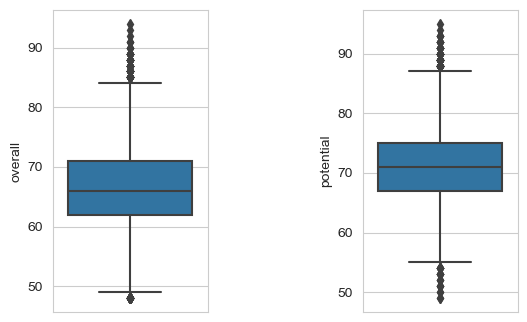

In [11]:
boxPlot(label1, label2, data)

<Figure size 6000x6000 with 0 Axes>

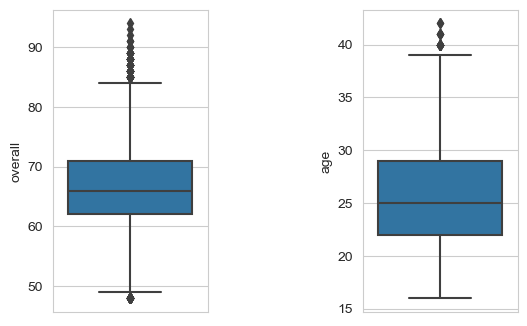

In [12]:
boxPlot(label1, label3, data2)

#### Formula to find out upper limit and lower limit from Outliers

In [13]:
def setbound(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    print(Q1, Q3)
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

#### Get the outliers data

In [14]:
def getOutlierData(data, mainData):
    lowerbound,upperbound = setbound(data)
    return mainData[(data < lowerbound) | (data > upperbound)]

#### Drop the outliers data

In [15]:
def outliering(idx1, idx2, mainData):
    while True:
        lowerbound,upperbound = setbound(mainData[idx1])
        res1 = getOutlierData(mainData[idx1], mainData)

        lowerbound,upperbound = setbound(mainData[idx2])
        res2 = getOutlierData(mainData[idx2], mainData)
        
        res = pd.concat([res1,res2]).drop_duplicates()
        res = res.index

        print('Total Outliers = ',len(res))
        print('=== The Outliers ===')
        print(res)    
        mainData.drop(res, inplace=True)

        if(len(res)==0):
            break
    print("BLOXPOT AFTER OUTLIERING")
    boxPlot(idx1, idx2, mainData)
    return mainData

62.0 71.0
62.0 71.0
67.0 75.0
67.0 75.0
Total Outliers =  94
=== The Outliers ===
Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,    10,
               11,    14,    16,    23,    24,    26,    27,    29,    40,
               42,    43,    44,    55,    56,    58,    60,    62,    64,
               73,    74,    75,    76,    80,    85,    86,    87,    96,
            18235, 18237, 18238, 18240, 18241, 18242, 18247, 18249, 18256,
            18258, 18260, 18262, 18264, 18271, 18272, 18273, 18276, 18277,
              108,   110,   111,   116,   157,   158,   162,   237,   238,
              329,   332,   411,   412,   568,   569,   571,   753,   754,
              992,  1254,  1255,  1257,  1615,  2121,  2122,  3288,  4041,
             4756, 17580, 17777, 17945, 17946, 18064, 18065, 18164, 18165,
            18167, 18230, 18232, 18233],
           dtype='int64')
62.0 71.0
62.0 71.0
67.0 75.0
67.0 75.0
Total Outliers =  49
=== The Outliers ===
Int64Index([    5, 

<Figure size 6000x6000 with 0 Axes>

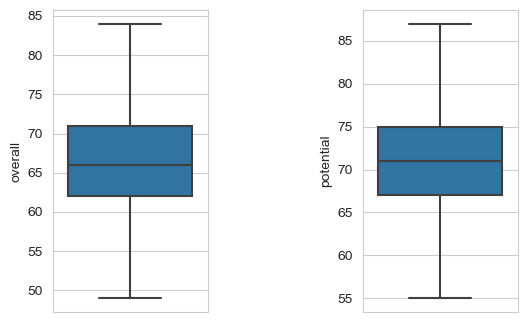

In [16]:
newData = outliering(label1, label2, data)

62.0 71.0
62.0 71.0
22.0 29.0
22.0 29.0
Total Outliers =  83
=== The Outliers ===
Int64Index([    0,     1,     2,     3,     4,     6,     8,    10,    11,
               12,    13,    16,    17,    18,    19,    20,    23,    24,
               26,    27,    29,    30,    31,    36,    37,    40,    41,
               42,    43,    44,    46,    47,    49,    52,    55,    56,
               57,    58,    60,    62,    64,    67,    69,    72,    73,
               74,    75,    76,    77,    78,    81,    86,    87,    92,
               96,    97,    99,   102, 18235, 18241, 18242, 18247, 18249,
            18260, 18273, 18277,   200,   868,  1880,  2963,  3706,  4417,
             6235,  7230,  8359, 10665, 10702, 11832, 13003, 14527, 15812,
            16314, 18233],
           dtype='int64')
62.0 71.0
62.0 71.0
22.0 29.0
22.0 29.0
Total Outliers =  35
=== The Outliers ===
Int64Index([    5,     7,    14,    21,    25,    28,    32,    33,    38,
               45,    48,    50, 

<Figure size 6000x6000 with 0 Axes>

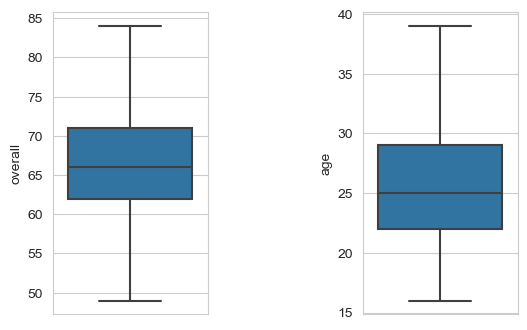

In [17]:
newData2 = outliering(label1, label3, data2)

Text(0, 0.5, 'potential')

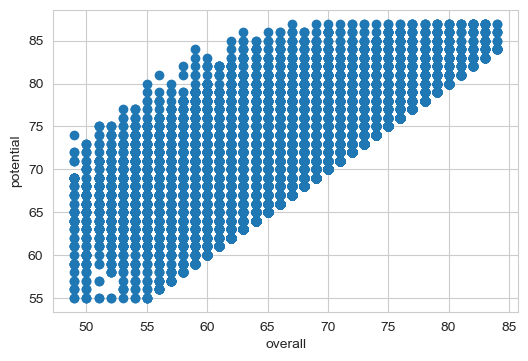

In [18]:
plt.scatter(newData[label1], newData[label2])
plt.xlabel(label1)
plt.ylabel(label2)

Text(0, 0.5, 'age')

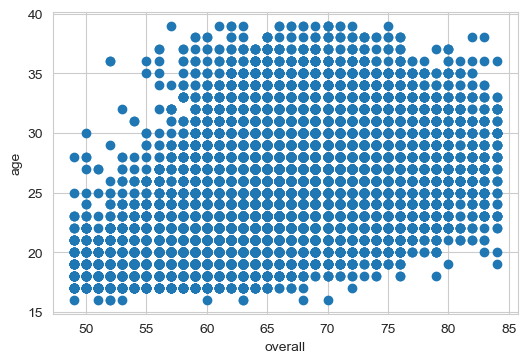

In [19]:
plt.scatter(newData2[label1], newData2[label3])
plt.xlabel(label1)
plt.ylabel(label3)

In [21]:
k = 4

#### Function to generate centroids

In [22]:
def generateCentroids(k, data1, data2):
    # Randomize value from 0 until max of data depend on size of k
    xCentroids = np.random.randint(np.min(data1), np.max(data1), size=k)
    yCentroids = np.random.randint(np.min(data2), np.max(data2), size=k) 
    
    # Merge X and Y Centroids
    centroids = np.array(list(zip(xCentroids, yCentroids)))
    return centroids, xCentroids, yCentroids

##### Generate centroids

In [23]:
centroids, x, y = generateCentroids(k,newData[label1],newData[label2])
centroids = sorted(centroids, key=lambda x:x[:][0], reverse=False)

centroids2, x2, y2 = generateCentroids(k,newData2[label1],newData2[label3])
centroids2 = sorted(centroids2, key=lambda y:y[:][0], reverse=False)

In [24]:
centroids = np.array(centroids)
centroids2 = np.array(centroids2)

In [25]:
centroids

array([[57, 74],
       [58, 78],
       [61, 82],
       [69, 57]])

In [26]:
centroids2

array([[57, 23],
       [67, 30],
       [78, 36],
       [81, 36]])

##### Plot first centroids

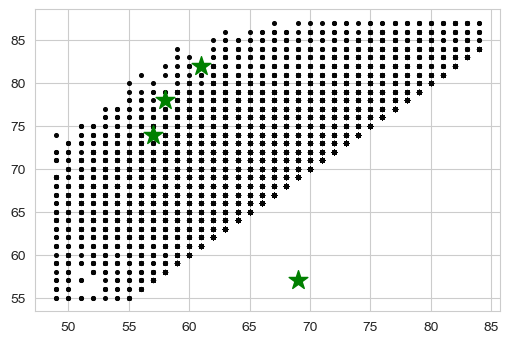

In [27]:
plt.scatter(newData[label1], newData[label2], c='#050505', s=7)
plt.scatter(x, y, marker='*', s=200, c='g')

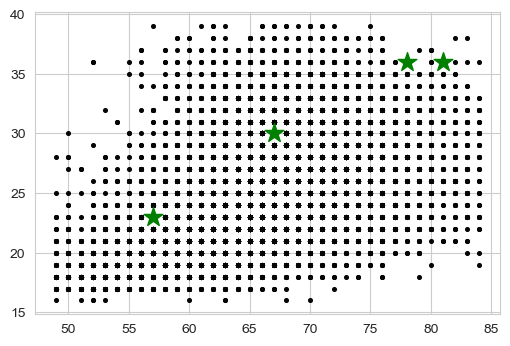

In [28]:
plt.scatter(newData2[label1], newData2[label3], c='#050505', s=7)
plt.scatter(x2, y2, marker='*', s=200, c='g')

#### Euclidean Distance Formula

In [29]:
def euclideanDistance(data, centroids, ax=1):
    return np.linalg.norm(data - centroids, axis=ax)

#### Convert data to array

In [30]:
npData = np.array(newData)
npData2 = np.array(newData2)

In [31]:
npData

array([[84, 87],
       [84, 87],
       [84, 86],
       ...,
       [49, 56],
       [49, 55],
       [49, 55]], dtype=int64)

In [32]:
npData2

array([[84, 19],
       [84, 20],
       [84, 22],
       ...,
       [49, 25],
       [49, 21],
       [49, 28]], dtype=int64)

#### Formula to update centroids based on the data

In [33]:
def updateCentroids(idx, clusters, data):
    points = np.array([data[j] for j in range(len(data)) if clusters[j] == idx])
    return points

## K-Means Function

In [34]:
def kMeans(k, data, centroids):
    # Set all cluster to 0
    clusters = np.zeros(len(data))
    clusters
    
    # assign old centroid as 0
    oldCentroid = np.zeros(centroids.shape)
    print("INITIALIZE CENTROIDS ", oldCentroid)
    
    # Error func. - Distance between new centroids and old centroids
    error = euclideanDistance(centroids, oldCentroid,None)
    print("INITIALIZE ERROR ", error)
    
    idx=0
    while error != 0:
        # Assigning each value to its closest cluster
        for i in range(len(data)):
            distances = euclideanDistance(data[i], centroids)
            cluster = np.argmin(distances)
            clusters[i] = cluster
            
        # Storing the old centroid values
        oldCentroid = deepcopy(centroids)
        
        # Finding the new centroids by taking the average value
        for i in range(k):
            points = updateCentroids(i,clusters, data) #[data[j] for j in range(len(data)) if clusters[j] == i]
            centroids[i] = np.mean(points, axis=0)
        error = euclideanDistance(centroids, oldCentroid, None)
        
    return centroids, clusters

In [35]:
lastCentroids, clusters = kMeans(k, npData, centroids)

INITIALIZE CENTROIDS  [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
INITIALIZE ERROR  191.38442987871298


In [36]:
lastCentroids2, clusters2 = kMeans(k, npData2, centroids2)

INITIALIZE CENTROIDS  [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
INITIALIZE ERROR  156.21779668142807


In [37]:
lastCentroids

array([[56, 65],
       [63, 74],
       [73, 76],
       [65, 66]])

In [38]:
lastCentroids2

array([[56, 20],
       [64, 22],
       [66, 30],
       [74, 26]])

In [39]:
clusters

array([2., 2., 2., ..., 0., 0., 0.])

In [40]:
clusters2

array([3., 3., 3., ..., 0., 0., 0.])

### The clustering result

In [41]:
def finalPlot(clusters, data, centroids):
    colors = ['r', 'gray', 'cyan','b', 'y', 'c', 'm', 'pink']
    fig, ax = plt.subplots()
    for i in range(k):
            points = updateCentroids(i, clusters, data)
            ax.scatter(points[:, 0], points[:, 1], c=colors[i])

    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=100, c='#050505')

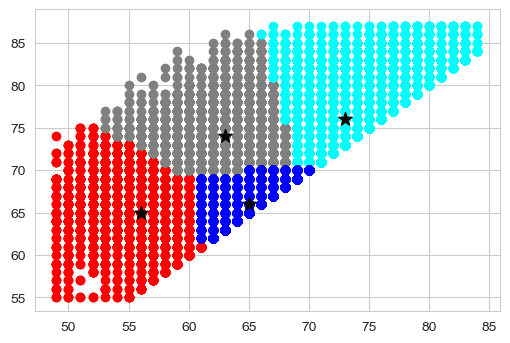

In [42]:
finalPlot(clusters, npData, lastCentroids)

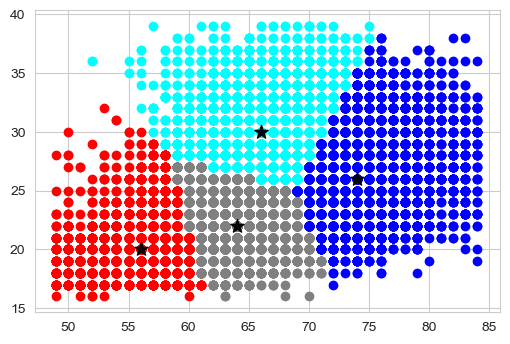

In [43]:
finalPlot(clusters2, npData2, lastCentroids2)

#### Evaluatin model using Silhouette Coefficient

In [48]:
np.mean(silhouette_samples(npData, clusters, metric='euclidean'))

0.37696984035297704

In [47]:
np.mean(silhouette_samples(npData2, clusters2, metric='euclidean'))

0.36285152469721244

## Kesimpulan

Dari hasil evaluasi, didapatkan hasil clustering yang lumayan baik dilihat dari nilai <i>silhouette coefficient</i> antar tetangga ada yang mirip dengan error data dengan centroid rata-rata hanya 36 - 37 %

<p>Copyright &copy; 2020 <a href=https://www.linkedin.com/in/pratamays/>Pratama Yoga Santosa</a> </p>